resources

- xarray pipeline example: https://github.com/openclimatefix/ocf_datapipes/blob/main/ocf_datapipes/training/pv_satellite_nwp.py
- https://discourse.pangeo.io/t/efficiently-slicing-random-windows-for-reduced-xarray-dataset/2447
- https://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9ddhttps://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9dd
- https://zen3geo.readthedocs.io/en/latest/chipping.htmlhttps://zen3geo.readthedocs.io/en/latest/chipping.html

In [1]:
# doesn't work:
#!pip install git+https://github.com/pytorch/data.git@9d91c666534633e94c71a248b839aef227adf5d1

In [2]:
%load_ext lab_black

In [3]:
import zen3geo
import xarray as xr
from torchdata.datapipes.iter import IterableWrapper
import torchdata.datapipes.utils
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchdata

torchdata.__version__, torch.__version__

('0.6.0.dev20221215', '2.0.0.dev20221215')

In [4]:
# based on https://github.com/weiji14/zen3geo/blob/main/zen3geo/datapipes/rioxarray.py

from torchdata.datapipes import functional_datapipe
from torchdata.datapipes.iter import IterDataPipe
from torchdata.datapipes.utils import StreamWrapper
from typing import Union
from typing import Any, Dict, Iterator, Optional
from pathlib import Path


@functional_datapipe("open_xarray_dataset")
class OpenXarrayDatasetIterDataPipe(IterDataPipe[StreamWrapper]):
    """ """

    _xr_open_method = xr.open_dataset

    def __init__(
        self, source_datapipe: IterDataPipe[str], **kwargs: Optional[Dict[str, Any]]
    ) -> None:
        self.source_datapipe: IterDataPipe[str] = source_datapipe
        self.kwargs = kwargs

    def __iter__(self) -> Iterator[StreamWrapper]:
        for filename in self.source_datapipe:
            # getting attribute via __class__ avoids `self` being passed in when we call the function
            yield StreamWrapper(self.__class__._xr_open_method(filename, **self.kwargs))

    def __len__(self) -> int:
        return len(self.source_datapipe)


@functional_datapipe("open_xarray_dataarray")
class OpenXarrayDataArrayIterDataPipe(OpenXarrayDatasetIterDataPipe):
    _xr_open_method = xr.open_dataarray

In [30]:
def xr_collate_fn(samples) -> torch.Tensor:
    """
    Converts individual xarray.DataArray objects to a torch.Tensor (float32
    dtype), and stacks them all into a single torch.Tensor.
    """
    tensors = []

    for sample in samples:
        data = sample.squeeze().data.astype(dtype="float32")
        if len(data.shape) == 2:
            # add channel axis if we've only got one channel
            data = data[np.newaxis, ...]
        tensor = torch.as_tensor(data=data)
        tensors.append(tensor)

    return torch.stack(tensors=tensors)

In [31]:
filepaths = [
    "rico.no_shear_br0.05.qv.tn6.nc",
]

In [32]:
tile_size = 128
dp = (
    IterableWrapper(filepaths)
    .open_xarray_dataarray()
    .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
    .batch(batch_size=2)
    .map(xr_collate_fn)
)

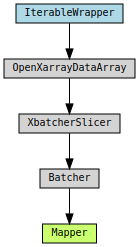

In [33]:
torchdata.datapipes.utils.to_graph(dp=dp)

In [34]:
next(iter(dp)).size()  # .squeeze()  # .plot()

torch.Size([2, 1, 128, 128])

In [10]:
dp.batch

functools.partial(<function IterDataPipe.register_datapipe_as_function.<locals>.class_function at 0x7f4ebd43c550>, <class 'torch.utils.data.datapipes.iter.grouping.BatcherIterDataPipe'>, False, MapperIterDataPipe)

## Normalization

- https://github.com/openclimatefix/ocf_datapipes/blob/main/ocf_datapipes/utils/consts.py

In [11]:
tile_size = 128
dp = IterableWrapper(filepaths).open_xarray_dataarray()

In [12]:
# I'm sure there are better ways of doing this, but how?


def aggregate_mean(stream):
    return xr.concat([item.file_obj for item in stream], dim="sample").mean()


def aggregate_std(stream):
    return xr.concat([item.file_obj for item in stream], dim="sample").std()


mean_global = next(iter(dp.zip().map(aggregate_mean))).item()
std_global = next(iter(dp.zip().map(aggregate_std))).item()

In [13]:
# based on https://github.com/openclimatefix/ocf_datapipes/blob/c317817bd207237a9cd5943f804cecb786f894a9/ocf_datapipes/transform/xarray/normalize.py

import logging
from typing import Callable, Optional, Union

import numpy as np
import xarray as xr
from torchdata.datapipes import functional_datapipe
from torchdata.datapipes.iter import IterDataPipe


@functional_datapipe("normalize_xr")
class NormalizeIterDataPipe(IterDataPipe):
    """Normalize the data with set of fixed mean and std values"""

    def __init__(
        self,
        source_datapipe: IterDataPipe,
        mean: Union[xr.Dataset, xr.DataArray, np.ndarray],
        std: Union[xr.Dataset, xr.DataArray, np.ndarray],
    ):
        self.source_datapipe = source_datapipe
        self.mean = mean
        self.std = std

    def __iter__(self) -> Union[xr.Dataset, xr.DataArray]:
        for xr_data in self.source_datapipe:
            long_name = xr_data.long_name
            xr_data = xr_data - self.mean
            xr_data = xr_data / self.std
            xr_data.attrs["long_name"] = f"Normalized {long_name}"
            xr_data.attrs["units"] = "1"
            yield xr_data

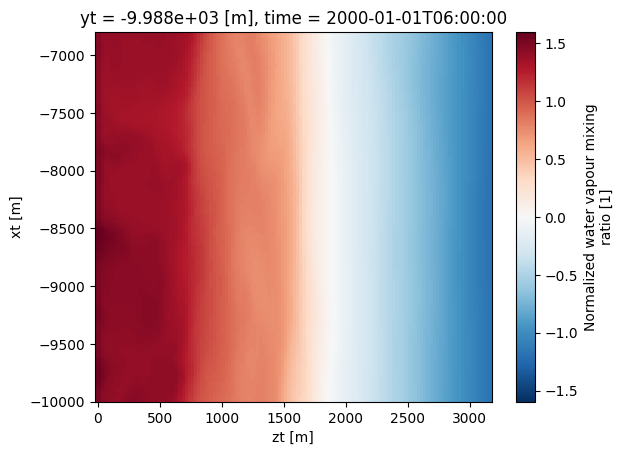

In [14]:
tile_size = 128
dp = (
    IterableWrapper(filepaths)
    .open_xarray_dataarray()
    .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
    .normalize_xr(std=std_global, mean=mean_global)
    # .batch(batch_size=2)
    # .map(xr_collate_fn)
)
next(iter(dp)).plot()

## adding noise

https://github.com/COMP6248-Reproducability-Challenge/selfsupervised-denoising

```
N2C: (noisy, clean)
N2N: (noisy1, noisy2)
N2V: (noisy, noisy)
SSDN: (noisy,)
```

In [15]:
# add IterDataPipe


@functional_datapipe("xr_add_noise")
class AddNoiseIterDataPipe(IterDataPipe):
    def __init__(self, source_datapipe: IterDataPipe[str], sigma=0.2) -> None:
        self.source_datapipe: IterDataPipe[str] = source_datapipe
        self.sigma = sigma

    def __iter__(self) -> Iterator[StreamWrapper]:
        for da in self.source_datapipe:
            sigma = 0.2
            noise = np.random.normal(scale=self.sigma, size=da.shape)
            da_noisy = da + noise
            da_noisy.attrs["long_name"] = f"{da.long_name} with added noise"
            da_noisy.attrs["units"] = da.units
            yield da_noisy

    def __len__(self) -> int:
        return len(self.source_datapipe)

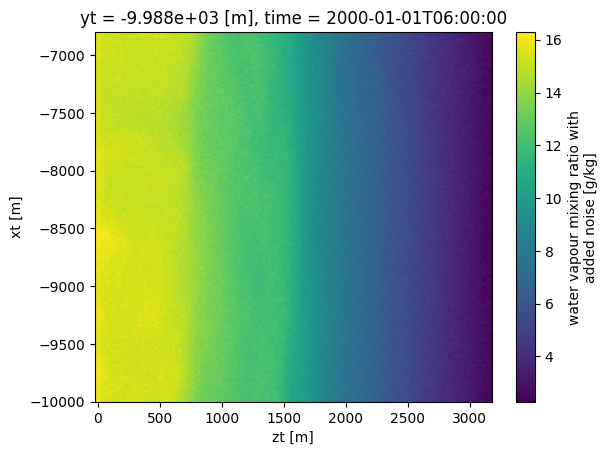

In [17]:
tile_size = 128
dp = (
    IterableWrapper(filepaths)
    .open_xarray_dataarray()
    .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
    .xr_add_noise(sigma=0.1)
)

next(iter(dp)).plot()

## using forking of datapipe

### common

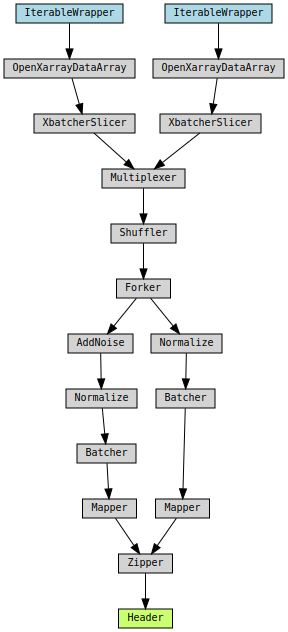

In [29]:
tile_size = 128


def create_benchmarking_pipeline(
    filepaths, model_name, n_samples=100, noise_sigma=0.2, tile_size=128, batch_size=16
):
    dp_chipped_input_x = (
        IterableWrapper(filepaths)
        .open_xarray_dataarray()
        .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
    )
    dp_chipped_input_y = (
        IterableWrapper(filepaths)
        .open_xarray_dataarray()
        .slice_with_xbatcher(input_dims=dict(yt=tile_size, xt=1, zt=tile_size))
    )
    dp_chipped_input = dp_chipped_input_x.mux(dp_chipped_input_y).shuffle()

    if model_name == "n2c":
        dp_clean, dp_noisy = dp_chipped_input.fork(num_instances=2)
        dp_noisy = dp_noisy.xr_add_noise(sigma=noise_sigma)
        dps = [dp_clean, dp_noisy]
    elif model_name == "n2n":
        dp_noisy1, dp_noisy2 = dp_chipped_input.fork(num_instances=2)
        dp_noisy1 = dp_noisy1.xr_add_noise(sigma=noise_sigma)
        dp_noisy2 = dp_noisy2.xr_add_noise(sigma=noise_sigma)
        dps = [dp_noisy1, dp_noisy2]
    elif model_name == "ssdn":
        dp_noisy = dp_chipped_input.xr_add_noise(sigma=noise_sigma)
        dps = [dp_noisy]
    else:
        raise NotImplementedError(model_name)

    for i in range(len(dps)):
        dps[i] = (
            dps[i]
            .normalize_xr(std=std_global, mean=mean_global)
            .batch(batch_size=batch_size)
            .map(xr_collate_fn)
        )

    if len(dps) > 1:
        dp = dps[0].zip(*dps[1:])
    else:
        dp = dps[0]

    return dp.header(n_samples)


dp = create_benchmarking_pipeline(filepaths, model_name="n2c", batch_size=2)
torchdata.datapipes.utils.to_graph(dp)

In [30]:
next(iter(dp))

(tensor([[[ 1.4687,  1.4687,  1.4113,  ..., -1.1275, -1.1471, -1.1641],
          [ 1.4731,  1.4731,  1.4135,  ..., -1.1283, -1.1478, -1.1647],
          [ 1.4748,  1.4748,  1.4149,  ..., -1.1291, -1.1485, -1.1654],
          ...,
          [ 1.4635,  1.4635,  1.4037,  ..., -1.1487, -1.1645, -1.1779],
          [ 1.4659,  1.4659,  1.4057,  ..., -1.1484, -1.1643, -1.1779],
          [ 1.4723,  1.4723,  1.4096,  ..., -1.1482, -1.1642, -1.1779]],
 
         [[ 1.4906,  1.4906,  1.4568,  ..., -1.1385, -1.1559, -1.1710],
          [ 1.4819,  1.4819,  1.4463,  ..., -1.1387, -1.1561, -1.1712],
          [ 1.4754,  1.4754,  1.4398,  ..., -1.1389, -1.1563, -1.1714],
          ...,
          [ 1.4947,  1.4947,  1.4268,  ..., -1.1434, -1.1599, -1.1741],
          [ 1.4986,  1.4986,  1.4240,  ..., -1.1428, -1.1594, -1.1736],
          [ 1.5067,  1.5067,  1.4257,  ..., -1.1423, -1.1589, -1.1732]]]),
 tensor([[[ 1.4229,  1.4737,  1.4440,  ..., -1.1955, -1.1841, -1.2305],
          [ 1.4285,  1.3774,

In [33]:
from tqdm import tqdm

In [35]:
for item in tqdm(dp.header(25)):
    pass

/home/leifdenby/mambaforge/envs/geodenoising/lib/python3.9/site-packages/torchdata/datapipes/iter/util/header.py:57: UserWarning: The length of this HeaderIterDataPipe is inferred to be equal to its limit.The actual value may be smaller if the actual length of source_datapipe is smaller than the limit.
  warn(
  0%|                                                                                                                              | 0/25 [00:00<?, ?it/s]/home/leifdenby/mambaforge/envs/geodenoising/lib/python3.9/site-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.34i

# train-test split

In [24]:
def create_training_benchmark_pipeline(
    filepaths,
    model_name,
    n_samples=100,
    train_test_split=0.9,
    tile_size=128,
    batch_size=16,
    seed=42,
    noise_sigma=0.2,
):
    dp = create_benchmarking_pipeline(
        filepaths=filepaths,
        model_name=model_name,
        tile_size=tile_size,
        batch_size=batch_size,
        n_samples=n_samples,
        noise_sigma=noise_sigma,
    )
    return dp.random_split(
        weights=dict(train=train_test_split, test=1.0 - train_test_split),
        seed=seed,
        total_length=n_samples,
    )


dp_train, dp_test = create_training_benchmark_pipeline(
    filepaths, model_name="n2c", batch_size=2
)

n = 0
for item in dp_train:
    n += 1

print(n)

90


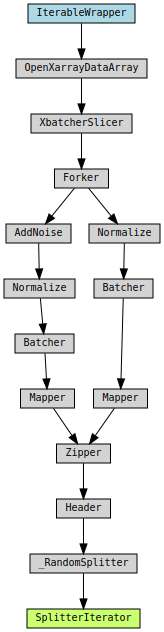

In [22]:
torchdata.datapipes.utils.to_graph(dp_train)

In [58]:
dp = IterableWrapper(range(10))
train, valid = dp.random_split(
    total_length=5, weights={"train": 0.5, "valid": 0.5}, seed=0
)
list(train)

ValueError: Total of weights must be greater than zero
This exception is thrown by __iter__ of SplitterIterator(main_datapipe=_RandomSplitterIterDataPipe, target='train')